# Disposition - Fastai Machine Learning

Question: Is it possible to build a machine learning model to predict KOI disposition based only upon score, fpflags and comments as input data?

Answer: I was able to train a fastai neural net with 83% accuracy!

In [1]:
# Python imports and settings
import numpy  as np
import pandas as pd
import seaborn as sns
import scipy.stats
import re
from pydash import py_ as _
from sklearn.preprocessing import OneHotEncoder

from src.dataset_koi import koi, koi_columns, koi_column_types
from src.utilities import onehot_encode_comments

# https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_rows', 8)  # 8 is required for .describe()

%load_ext autoreload
%autoreload 2

In [2]:
import random
import fastai
from fastai.basic_data import DatasetType
from fastai.tabular.data import TabularDataBunch, TabularList
from fastai.tabular.transform import FillMissing, Categorify, Normalize
from fastai.tabular.learner import tabular_learner
from fastai.metrics import accuracy, r2_score, root_mean_squared_error, mean_squared_logarithmic_error
from fastai.data_block import FloatList

## Load Dataset

In [3]:
dataset            = pd.DataFrame.join( koi['archive'], koi['disposition'] ); 
onehot_disposition = pd.get_dummies(dataset[['koi_disposition']])
onehot_comments    = onehot_encode_comments(dataset, 'koi_comment', '---', without=['NO_COMMENT']).astype('int32')

onehot_dataset = (
    pd.concat([ 
        koi['archive'], 
        onehot_disposition,
        koi['disposition'],
        onehot_comments,
    ], axis=1)
    .drop(columns=['koi_comment'])
)
onehot_dataset

,kepler_name,koi_disposition,koi_disposition_CANDIDATE,koi_disposition_CONFIRMED,koi_disposition_FALSE POSITIVE,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_comment_ALL_TRANS_CHASES,koi_comment_ALT_ROBO_ODD_EVEN_TEST_FAIL,koi_comment_ALT_SEC_SAME_DEPTH_AS_PRI_COULD_BE_TWICE_TRUE_PERIOD,koi_comment_ALT_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_ALT_SIG_PRI_MINUS_SIG_TER_TOO_LOW,koi_comment_ALT_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_CENTROID_SIGNIF_UNCERTAIN,koi_comment_CENT_CROWDED,koi_comment_CENT_FEW_DIFFS,koi_comment_CENT_FEW_MEAS,koi_comment_CENT_KIC_POS,koi_comment_CENT_NOFITS,koi_comment_CENT_RESOLVED_OFFSET,koi_comment_CENT_SATURATED,koi_comment_CENT_UNCERTAIN,koi_comment_CENT_UNRESOLVED_OFFSET,koi_comment_CLEAR_APO,koi_comment_CROWDED_DIFF,koi_comment_DEEP_V_SHAPED,koi_comment_DEPTH_ODDEVEN_ALT,koi_comment_DEPTH_ODDEVEN_DV,koi_comment_DV_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_DV_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_EPHEM_MATCH,koi_comment_EYEBALL,koi_comment_FIT_FAILED,koi_comment_HALO_GHOST,koi_comment_HAS_SEC_TCE,koi_comment_INCONSISTENT_TRANS,koi_comment_INDIV_TRANS_CHASES,koi_comment_INDIV_TRANS_CHASES_MARSHALL,koi_comment_INDIV_TRANS_CHASES_MARSHALL_SKYE,koi_comment_INDIV_TRANS_CHASES_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_CHASES_SKYE,koi_comment_INDIV_TRANS_MARSHALL,koi_comment_INDIV_TRANS_MARSHALL_SKYE,koi_comment_INDIV_TRANS_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_RUBBLE,koi_comment_INDIV_TRANS_RUBBLE_MARSHALL_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_SKYE,koi_comment_INDIV_TRANS_SKYE_ZUMA,koi_comment_INDIV_TRANS_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_ZUMA,koi_comment_INVERT_DIFF,koi_comment_IS_SEC_TCE,koi_comment_KIC_OFFSET,koi_comment_LPP_ALT,koi_comment_LPP_ALT_TOO_HIGH,koi_comment_LPP_DV,koi_comment_LPP_DV_TOO_HIGH,koi_comment_MARSHALL_FAIL,koi_comment_MOD_NONUNIQ_ALT,koi_comment_MOD_NONUNIQ_DV,koi_comment_MOD_ODDEVEN_ALT,koi_comment_MOD_ODDEVEN_DV,koi_comment_MOD_POS_ALT,koi_comment_MOD_POS_DV,koi_comment_MOD_SEC_ALT,koi_comment_MOD_SEC_DV,koi_comment_MOD_TER_ALT,koi_comment_MOD_TER_DV,koi_comment_OTHER_TCE_AT_SAME_PERIOD_DIFF_EPOCH,koi_comment_PARENT_IS_002305372-pri,koi_comment_PARENT_IS_002449084-pri,koi_comment_PARENT_IS_003352751-pri,koi_comment_PARENT_IS_003858884-01,koi_comment_PARENT_IS_004482641-01,koi_comment_PARENT_IS_005024292-01,koi_comment_PARENT_IS_005036538-01,koi_comment_PARENT_IS_005343976-pri,koi_comment_PARENT_IS_005471619-pri,koi_comment_PARENT_IS_005513861-pri,koi_comment_PARENT_IS_006367628-pri,koi_comment_PARENT_IS_007258889-pri,koi_comment_PARENT_IS_007598128-pri,koi_comment_PARENT_IS_008265951-pri,koi_comment_PARENT_IS_008380743-pri,koi_comment_PARENT_IS_009541127-pri,koi_comment_PARENT_IS_009777062-01,koi_comment_PARENT_IS_010485137-pri,koi_comment_PARENT_IS_010858720-pri,koi_comment_PARENT_IS_012004679-pri,koi_comment_PARENT_IS_3597.01,koi_comment_PARENT_IS_3895.01,koi_comment_PARENT_IS_4673.01,koi_comment_PARENT_IS_489.01,koi_comment_PARENT_IS_5335.01,koi_comment_PARENT_IS_970.01,koi_comment_PARENT_IS_FL-Lyr-pri,koi_comment_PARENT_IS_RR-Lyr-pri,koi_comment_PARENT_IS_UZ-Lyr-pri,koi_comment_PARENT_IS_V2277-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-sec,koi_comment_PARENT_IS_V850-Cyg-pri,koi_comment_PERIOD_ALIAS_ALT,koi_comment_PERIOD_ALIAS_DV,koi_comment_PERIOD_ALIAS_IN_ALT_DATA_SEEN_AT_3:1,koi_comment_PERIOD_ALIAS_IN_DV_DATA_SEEN_AT_3:1,koi_comment_PLANET_IN_STAR,koi_comment_PLANET_OCCULT_ALT,koi_comment_PLANET_OCCULT_DV,koi_comment_PLANET_PERIOD_IS_HALF_ALT,koi_comment_PLANET_PERIOD_IS_HALF_DV,koi_comment_RESIDUAL_TCE,koi_comment_RESID_OF_PREV_TCE,koi_comment_SAME_NTL_PERIOD,koi_comment_SAME_P_AS_PREV_NTL_TCE,koi_comment_SATURATED,koi_comment_SEASONAL_DEPTH_ALT,koi_comment_SEASONAL_DEPTH_DIFFS_IN_ALT,koi_comment_SEASONAL_DEPTH_DV,koi_comment_SIGNIF_OFFSET,koi_comment_SIG_SEC_IN_ALT_MODEL_SHIFT,

In [4]:
ml_dataset = (
    onehot_dataset
        .filter(regex='^koi_disposition$|^koi_score|^koi_fpflag_|^koi_comment_')
        .reset_index()
        .drop('kepoi_name', axis=1)
)
ml_dataset

,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_comment_ALL_TRANS_CHASES,koi_comment_ALT_ROBO_ODD_EVEN_TEST_FAIL,koi_comment_ALT_SEC_SAME_DEPTH_AS_PRI_COULD_BE_TWICE_TRUE_PERIOD,koi_comment_ALT_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_ALT_SIG_PRI_MINUS_SIG_TER_TOO_LOW,koi_comment_ALT_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_CENTROID_SIGNIF_UNCERTAIN,koi_comment_CENT_CROWDED,koi_comment_CENT_FEW_DIFFS,koi_comment_CENT_FEW_MEAS,koi_comment_CENT_KIC_POS,koi_comment_CENT_NOFITS,koi_comment_CENT_RESOLVED_OFFSET,koi_comment_CENT_SATURATED,koi_comment_CENT_UNCERTAIN,koi_comment_CENT_UNRESOLVED_OFFSET,koi_comment_CLEAR_APO,koi_comment_CROWDED_DIFF,koi_comment_DEEP_V_SHAPED,koi_comment_DEPTH_ODDEVEN_ALT,koi_comment_DEPTH_ODDEVEN_DV,koi_comment_DV_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_DV_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_EPHEM_MATCH,koi_comment_EYEBALL,koi_comment_FIT_FAILED,koi_comment_HALO_GHOST,koi_comment_HAS_SEC_TCE,koi_comment_INCONSISTENT_TRANS,koi_comment_INDIV_TRANS_CHASES,koi_comment_INDIV_TRANS_CHASES_MARSHALL,koi_comment_INDIV_TRANS_CHASES_MARSHALL_SKYE,koi_comment_INDIV_TRANS_CHASES_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_CHASES_SKYE,koi_comment_INDIV_TRANS_MARSHALL,koi_comment_INDIV_TRANS_MARSHALL_SKYE,koi_comment_INDIV_TRANS_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_RUBBLE,koi_comment_INDIV_TRANS_RUBBLE_MARSHALL_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_SKYE,koi_comment_INDIV_TRANS_SKYE_ZUMA,koi_comment_INDIV_TRANS_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_ZUMA,koi_comment_INVERT_DIFF,koi_comment_IS_SEC_TCE,koi_comment_KIC_OFFSET,koi_comment_LPP_ALT,koi_comment_LPP_ALT_TOO_HIGH,koi_comment_LPP_DV,koi_comment_LPP_DV_TOO_HIGH,koi_comment_MARSHALL_FAIL,koi_comment_MOD_NONUNIQ_ALT,koi_comment_MOD_NONUNIQ_DV,koi_comment_MOD_ODDEVEN_ALT,koi_comment_MOD_ODDEVEN_DV,koi_comment_MOD_POS_ALT,koi_comment_MOD_POS_DV,koi_comment_MOD_SEC_ALT,koi_comment_MOD_SEC_DV,koi_comment_MOD_TER_ALT,koi_comment_MOD_TER_DV,koi_comment_OTHER_TCE_AT_SAME_PERIOD_DIFF_EPOCH,koi_comment_PARENT_IS_002305372-pri,koi_comment_PARENT_IS_002449084-pri,koi_comment_PARENT_IS_003352751-pri,koi_comment_PARENT_IS_003858884-01,koi_comment_PARENT_IS_004482641-01,koi_comment_PARENT_IS_005024292-01,koi_comment_PARENT_IS_005036538-01,koi_comment_PARENT_IS_005343976-pri,koi_comment_PARENT_IS_005471619-pri,koi_comment_PARENT_IS_005513861-pri,koi_comment_PARENT_IS_006367628-pri,koi_comment_PARENT_IS_007258889-pri,koi_comment_PARENT_IS_007598128-pri,koi_comment_PARENT_IS_008265951-pri,koi_comment_PARENT_IS_008380743-pri,koi_comment_PARENT_IS_009541127-pri,koi_comment_PARENT_IS_009777062-01,koi_comment_PARENT_IS_010485137-pri,koi_comment_PARENT_IS_010858720-pri,koi_comment_PARENT_IS_012004679-pri,koi_comment_PARENT_IS_3597.01,koi_comment_PARENT_IS_3895.01,koi_comment_PARENT_IS_4673.01,koi_comment_PARENT_IS_489.01,koi_comment_PARENT_IS_5335.01,koi_comment_PARENT_IS_970.01,koi_comment_PARENT_IS_FL-Lyr-pri,koi_comment_PARENT_IS_RR-Lyr-pri,koi_comment_PARENT_IS_UZ-Lyr-pri,koi_comment_PARENT_IS_V2277-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-sec,koi_comment_PARENT_IS_V850-Cyg-pri,koi_comment_PERIOD_ALIAS_ALT,koi_comment_PERIOD_ALIAS_DV,koi_comment_PERIOD_ALIAS_IN_ALT_DATA_SEEN_AT_3:1,koi_comment_PERIOD_ALIAS_IN_DV_DATA_SEEN_AT_3:1,koi_comment_PLANET_IN_STAR,koi_comment_PLANET_OCCULT_ALT,koi_comment_PLANET_OCCULT_DV,koi_comment_PLANET_PERIOD_IS_HALF_ALT,koi_comment_PLANET_PERIOD_IS_HALF_DV,koi_comment_RESIDUAL_TCE,koi_comment_RESID_OF_PREV_TCE,koi_comment_SAME_NTL_PERIOD,koi_comment_SAME_P_AS_PREV_NTL_TCE,koi_comment_SATURATED,koi_comment_SEASONAL_DEPTH_ALT,koi_comment_SEASONAL_DEPTH_DIFFS_IN_ALT,koi_comment_SEASONAL_DEPTH_DV,koi_comment_SIGNIF_OFFSET,koi_comment_SIG_SEC_IN_ALT_MODEL_SHIFT,koi_comment_SIG_SEC_IN_DV_MODEL_SHIFT,koi_comment_SWEET_EB,koi_comment_SWEET_NTL,koi_comment_TOO_FEW_CENTROIDS,k

In [5]:
ml_dataset.dtypes.koi_disposition  # fastai uses dtype to imply categorization (int, Categorical) vs regression (float)

CategoricalDtype(categories=['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'], ordered=False)

## Define fastai ML model

In [6]:
valid_idx  = random.sample( ml_dataset.index.tolist(), len(ml_dataset)//3 )
cat_names  = ml_dataset['koi_disposition'].unique().tolist()
cont_names = _(ml_dataset.columns.tolist()).without('koi_disposition').value()  # important to exclude Y from X

In [20]:
# DOCS: https://docs.fast.ai/tabular.data.html#TabularDataBunch.from_df
databunch = TabularDataBunch.from_df(
    path='', 
    df=ml_dataset,
    test_df=onehot_dataset,
    dep_var='koi_disposition', 
    valid_idx=valid_idx,
    procs=[FillMissing, Categorify], 
#     cat_names=cat_names,
    cont_names=cont_names,    
)

### TabularList is required when using learn.predict(row) - but this method is very slow
# datalist = TabularList.from_df(
#     df=onehot_dataset,
#     procs=[FillMissing, Categorify], 
#     cat_names=cat_names,
#     cont_names=cont_names, 
# )

assert( 'koi_disposition' not in databunch.train_ds.cont_names )

In [75]:
# learn.load('disposition')  # load previously saved model

In [25]:
# DOCS: https://docs.fast.ai/tabular.data.html#tabular_learner
learn = tabular_learner(
    data=databunch, 
    layers=[200, 200, 100, 100, 50, 50],
    metrics=[accuracy],                           
    wd=0.1,
    emb_drop=0.5,
)
# learn  # very verbose output

## Train Model

Use the learning rate finder, and pick a point on the main downward slope. A little experimention was required to obtain super-convergence without divergence.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


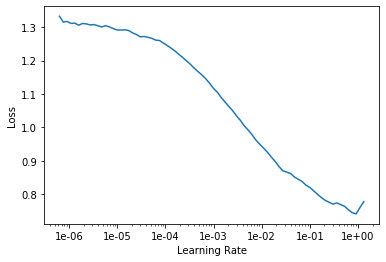

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
# learn.fit_one_cycle(10, 1e-3)  # [200, 200, 200, 200]                     accuracy = 0.836297 | wd=0.2
# learn.fit_one_cycle(10, 1e-4)  # [1000, 500, 250, 125]                    accuracy = 0.832636 | wd=0.2
# learn.fit_one_cycle(10, 1e-4)  # [500, 250, 125]                          accuracy = 0.824268 | wd=0.2
# learn.fit_one_cycle(10, 1e-3)  # [200, 200, 100, 100, 50, 50]             accuracy = 0.836297 | wd=0.2
# learn.fit_one_cycle(10, 1e-3)  # [200, 200, 100, 100, 50, 50]             accuracy = 0.815900 | wd=0.1
# learn.fit_one_cycle(100,1e-3)  # [200, 200, 100, 100, 50, 50]             accuracy = 0.273758	0.399271	0.830021	00:04 | wd=default 
# learn.fit_one_cycle(20, 1e-3)  # [200, 200, 100, 100, 50, 50] wd=default           | 0.290141	0.492101	0.825314	00:05 | 
# learn.fit_one_cycle(20, 1e-4)  # [200, 200, 100, 50] wd=0.1 emb_drop=0.5,          | 0.301931	0.575451	0.845044	00:04
# learn.fit_one_cycle(10, 1e-4)  # [200, 200, 100, 50] wd=0.1 emb_drop=0.5,          | 0.330207	0.552282	0.838143	00:03
# learn.fit_one_cycle(30, 2e-4)  # [200, 200, 100, 50] wd=0.1 emb_drop=0.5,          | 0.290738	0.839517	0.851317	00:03
# learn.fit_one_cycle(20, 1e-4)  # [200, 200, 100, 100, 50, 50] wd=0.2 emb_drop=0.5  | 0.286790	0.734067	0.848808	00:03
learn.fit_one_cycle(20, 1e-3)    # [200, 200, 100, 100, 50, 50] wd=0.2 emb_drop=0.5  | 0.288875	0.447987	0.837829	00:04

epoch,train_loss,valid_loss,accuracy,time
0,0.761726,0.730114,0.783250,00:04
1,0.509670,0.510588,0.827792,00:04
2,0.396001,0.493818,0.826851,00:04
3,0.354286,0.430382,0.835320,00:04
4,0.330938,0.497959,0.836888,00:04
5,0.320326,0.612741,0.832811,00:04
6,0.322452,0.645063,0.837829,00:04
7,0.311791,0.447237,0.740276,00:04
8,0.308034,0.499473,0.744668,00:04
9,0.312623,0.505758,0.738394,00:04


NOTE: it is important that the validation error continues to follow a general downward trend without diverging either upwards or too far from the training error. 

There is some overfitting here, but the overall result is reasonable.

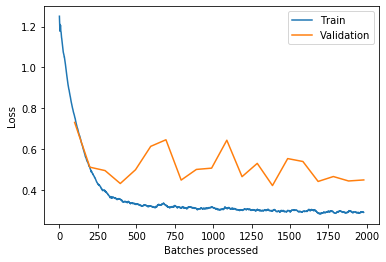

In [28]:
learn.recorder.plot_losses()

In [74]:
learn.save('disposition')

In [12]:
### This method is horrendously slow 
# predictions = [ learn.predict(row)[0] for row in datalist ]  

## Generate Predictions

In [29]:
def label_predict(learn, preds):
    return [ learn.data.classes[np.argmax(pred)] for pred in preds ]

# HACK: Inject onehot_dataset in df_test, as learn.get_preds() is very much faster than learn.predict(row)[0]
predict, _     = learn.get_preds(ds_type=DatasetType.Test)
predict_labels = label_predict(learn, predict)
assert len(predict) == len(onehot_dataset)

onehot_dataset.drop('predict', axis=1, errors='ignore', inplace=True)
onehot_dataset.insert(1, 'predict', predict_labels)

In [73]:
accuracy = onehot_dataset.query('predict == koi_disposition').shape[0] / onehot_dataset.shape[0]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'Accuracy: {round(accuracy*100, 2)}%' )
    print('\n----------\n')
    print('Confusion Matrix')
    display( onehot_dataset
            .sort_values(['predict', 'koi_disposition']) 
            .groupby(['predict', 'koi_disposition']) 
            .size()
    )    
    print('\n----------\n')
    print('Examples of each combination of true positive and false negative')
    display( onehot_dataset
            # .query('predict != koi_disposition')
            .sort_values(['predict', 'koi_disposition']) 
            .groupby(['predict', 'koi_disposition']) 
            .apply(lambda group:group.head(2))
   )

Accuracy: 83.26%

----------

Confusion Matrix


predict         koi_disposition
CANDIDATE       CANDIDATE          1865
                CONFIRMED          898 
                FALSE POSITIVE     132 
CONFIRMED       CANDIDATE          544 
                CONFIRMED          1397
                FALSE POSITIVE     8   
FALSE POSITIVE  CANDIDATE          11  
                CONFIRMED          8   
                FALSE POSITIVE     4701
dtype: int64


----------

Examples of each combination of true positive and false negative


kepler_name         predict koi_disposition  koi_disposition_CANDIDATE  koi_disposition_CONFIRMED  koi_disposition_FALSE POSITIVE koi_pdisposition  koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_comment_ALL_TRANS_CHASES  koi_comment_ALT_ROBO_ODD_EVEN_TEST_FAIL  koi_comment_ALT_SEC_SAME_DEPTH_AS_PRI_COULD_BE_TWICE_TRUE_PERIOD  koi_comment_ALT_SIG_PRI_MINUS_SIG_POS_TOO_LOW  koi_comment_ALT_SIG_PRI_MINUS_SIG_TER_TOO_LOW  koi_comment_ALT_SIG_PRI_OVER_FRED_TOO_LOW  koi_comment_CENTROID_SIGNIF_UNCERTAIN  koi_comment_CENT_CROWDED  koi_comment_CENT_FEW_DIFFS  koi_comment_CENT_FEW_MEAS  koi_comment_CENT_KIC_POS  koi_comment_CENT_NOFITS  koi_comment_CENT_RESOLVED_OFFSET  koi_comment_CENT_SATURATED  koi_comment_CENT_UNCERTAIN  koi_comment_CENT_UNRESOLVED_OFFSET  koi_comment_CLEAR_APO  koi_comment_CROWDED_DIFF  koi_comment_DEEP_V_SHAPED  koi_comment_DEPTH_ODDEVEN_ALT  koi_comment_DEPTH_ODDEVEN_DV  koi_comment_DV_SIG_PRI_MINUS_SIG_POS_TOO_LOW  koi_comment_DV_SIG_PRI_OVER_FRED_TOO_LOW  koi_comment_EPHEM_MATCH  koi_comment_EYEBALL  koi_comment_FIT_FAILED  koi_comment_HALO_GHOST  koi_comment_HAS_SEC_TCE  koi_comment_INCONSISTENT_TRANS  koi_comment_INDIV_TRANS_CHASES  koi_comment_INDIV_TRANS_CHASES_MARSHALL  koi_comment_INDIV_TRANS_CHASES_MARSHALL_SKYE  koi_comment_INDIV_TRANS_CHASES_MARSHALL_ZUMA  koi_comment_INDIV_TRANS_CHASES_SKYE  koi_comment_INDIV_TRANS_MARSHALL  koi_comment_INDIV_TRANS_MARSHALL_SKYE  koi_comment_INDIV_TRANS_MARSHALL_ZUMA  koi_comment_INDIV_TRANS_RUBBLE  koi_comment_INDIV_TRANS_RUBBLE_MARSHALL_SKYE  koi_comment_INDIV_TRANS_RUBBLE_SKYE  koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA  koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA_TRACKER  koi_comment_INDIV_TRANS_SKYE  koi_comment_INDIV_TRANS_SKYE_ZUMA  koi_comment_INDIV_TRANS_SKYE_ZUMA_TRACKER  koi_comment_INDIV_TRANS_ZUMA  koi_comment_INVERT_DIFF  koi_comment_IS_SEC_TCE  koi_comment_KIC_OFFSET  koi_comment_LPP_ALT  koi_comment_LPP_ALT_TOO_HIGH  koi_comment_LPP_DV  koi_comment_LPP_DV_TOO_HIGH  koi_comment_MARSHALL_FAIL  koi_comment_MOD_NONUNIQ_ALT  koi_comment_MOD_NONUNIQ_DV  koi_comment_MOD_ODDEVEN_ALT  koi_comment_MOD_ODDEVEN_DV  koi_comment_MOD_POS_ALT  koi_comment_MOD_POS_DV  koi_comment_MOD_SEC_ALT  koi_comment_MOD_SEC_DV  koi_comment_MOD_TER_ALT  koi_comment_MOD_TER_DV  koi_comment_OTHER_TCE_AT_SAME_PERIOD_DIFF_EPOCH  koi_comment_PARENT_IS_002305372-pri  koi_comment_PARENT_IS_002449084-pri  koi_comment_PARENT_IS_003352751-pri  koi_comment_PARENT_IS_003858884-01  koi_comment_PARENT_IS_004482641-01  koi_comment_PARENT_IS_005024292-01  koi_comment_PARENT_IS_005036538-01  koi_comment_PARENT_IS_005343976-pri  koi_comment_PARENT_IS_005471619-pri  koi_comment_PARENT_IS_005513861-pri  koi_comment_PARENT_IS_006367628-pri  koi_comment_PARENT_IS_007258889-pri  koi_comment_PARENT_IS_007598128-pri  koi_comment_PARENT_IS_008265951-pri  koi_comment_PARENT_IS_008380743-pri  koi_comment_PARENT_IS_009541127-pri  koi_comment_PARENT_IS_009777062-01  koi_comment_PARENT_IS_010485137-pri  koi_comment_PARENT_IS_010858720-pri  koi_comment_PARENT_IS_012004679-pri  koi_comment_PARENT_IS_3597.01  koi_comment_PARENT_IS_3895.01  koi_comment_PARENT_IS_4673.01  koi_comment_PARENT_IS_489.01  koi_comment_PARENT_IS_5335.01  koi_comment_PARENT_IS_970.01  koi_comment_PARENT_IS_FL-Lyr-pri  koi_comment_PARENT_IS_RR-Lyr-pri  koi_comment_PARENT_IS_UZ-Lyr-pri  koi_comment_PARENT_IS_V2277-Cyg-pri  koi_comment_PARENT_IS_V380-Cyg-pri  koi_comment_PARENT_IS_V380-Cyg-sec  koi_comment_PARENT_IS_V850-Cyg-pri  koi_comment_PERIOD_ALIAS_ALT  koi_comment_PERIOD_ALIAS_DV  koi_comment_PERIOD_ALIAS_IN_ALT_DATA_SEEN_AT_3:1  koi_comment_PERIOD_ALIAS_IN_DV_DATA_SEEN_AT_3:1  koi_comment_PLANET_IN_STAR  koi_comment_PLANET_OCCULT_ALT  koi_comment_PLANET_OCCULT_DV  koi_comment_PLANET_PERIOD_IS_HALF_ALT  koi_comment_PLANET_PERIOD_IS_HALF_DV  koi_comment_RESIDUAL_TCE  koi_comment_RESID_OF_PREV_TCE  koi_comment_SAME_NTL_PERIOD  koi_comment_SAME_P_AS_PREV_NTL_TCE  koi_comment_SATURATED  koi_comment_SEASONAL_DEPTH_ALT